DMS task analysis (extended figures 6 and 9).

In [ ]:
from low_rank_rnns.modules import *
import matplotlib
from low_rank_rnns import dms, ranktwo, clustering, helpers
import seaborn as sns

In [2]:
helpers.setup_matplotlib()
colors = ['seagreen', 'rebeccapurple']

In [3]:
def time_mapping(t):
    return t * dms.deltaT / 1000

In [4]:
hidden_size = 4096
noise_std = 5e-2
alpha = 0.2
x_train, y_train, mask_train, x_val, y_val, mask_val = dms.generate_dms_data(1000)
net = LowRankRNN(2, hidden_size, 1, noise_std, alpha, rank=2)
net.load_state_dict(torch.load(f'../models/dms_rank2_{hidden_size}.pt', map_location='cpu'))
net.svd_reparametrization()

In [5]:
loss_orig, acc_orig = dms.test_dms(net, x_val, y_val, mask_val)
print(acc_orig)
print(loss_orig)

1.0
0.00047544631524942815


In [6]:
m1 = net.m[:,0].detach().numpy()
m2 = net.m[:,1].detach().numpy()
n1 = net.n[:,0].detach().numpy()
n2 = net.n[:,1].detach().numpy()
wi1 = net.wi_full[0].detach().numpy()
wi2 = net.wi_full[1].detach().numpy()
wo = net.wo_full[:,0].detach().numpy()

In [7]:
n_pops = 2
vecs = [n1, n2, m1, m2, wi1, wi2]
z, model = clustering.gmm_fit(vecs, n_pops, algo='bayes', n_init=50, random_state=2020, mean_precision_prior=1e5)

../low_rank_rnns/ranktwo.py:339: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolor(X, Y, norm_field)


[Text(1, 0.1, '$0.1$'), Text(1, 0.9, '$0.9$')]

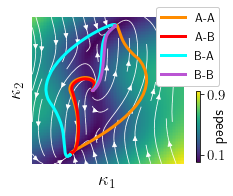

In [8]:
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.labelpad'] = 0
plt.rcParams['xtick.labelsize'] = 12
dms.decision_duration = 2000
dms.setup()
fig, ax = plt.subplots(figsize=(3, 3))
mappable = dms.plot_trajectories_summary_ranktwo(net, rect=(-2, 3, -3, 3), scalings=False, legend=False, 
                                                 figsize=(2.7, 2.7), timepoints=False, ax=ax)
ax.set_xlabel('$\kappa_1$')
ax.set_ylabel('$\kappa_2$')
ax.legend(loc='upper right', framealpha=1, frameon=True, bbox_to_anchor=(1.2, 1.05), fontsize=12)
ax_cbar = fig.add_axes((.92, .17, .02, .33))
cbar = plt.colorbar(mappable, cax=ax_cbar)
cbar.set_ticks([0.1, .9])
cbar.set_label('speed', rotation=270, fontsize=15, labelpad=.3)
ax_cbar.yaxis.set_ticklabels(['$0.1$', '$0.9$'], fontsize=15)
# plt.savefig('figure_4/dms_trajectories.pdf', bbox_inches='tight')

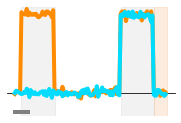

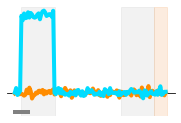

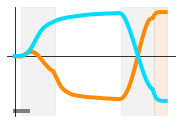

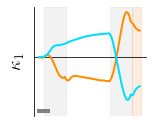

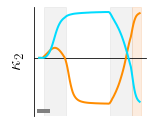

In [9]:
# Setting up task
dms.stimulus1_duration_min = 500
dms.stimulus1_duration_max = 500
dms.delay_duration_min = 1000
dms.delay_duration_max = 1000
dms.stimulus2_duration_min = 500
dms.stimulus2_duration_max = 500
dms.decision_duration = 200
dms.setup()
net.noise_std = noise_std

# Durations
stim1_beg = dms.fixation_duration_discrete
stim1_end = stim1_beg + dms.min_stimulus1_duration_discrete
stim2_beg = stim1_end + dms.min_delay_duration_discrete
stim2_end = stim2_beg + dms.min_stimulus2_duration_discrete
decision_end = stim2_end + dms.decision_duration_discrete
time = time_mapping(np.arange(decision_end))

# Figures parameters
col_AA = 'darkorange'
col_BA = '#00dcff'
plot_w = 4

x1 = dms.generate_dms_data(1, type='A-A')[0]
x2 = dms.generate_dms_data(1, type='B-A')[0]

outp1, traj1 = net.forward(x1, return_dynamics=True)
outp2, traj2 = net.forward(x2, return_dynamics=True)
x1 = x1.squeeze().numpy()
x2 = x2.squeeze().numpy()
traj1 = traj1.detach().squeeze().numpy()
traj2 = traj2.detach().squeeze().numpy()
rates1 = np.tanh(traj1)
rates2 = np.tanh(traj2)
outp1 = outp1.detach().squeeze().numpy()
outp2 = outp2.detach().squeeze().numpy()

def plot_periods(ax):
    ax.axvspan(time_mapping(stim1_beg), time_mapping(stim1_end), color='silver', alpha=.2)
    ax.axvspan(time_mapping(stim2_beg), time_mapping(stim2_end), color='silver', alpha=.2)
    ax.axvspan(time_mapping(stim2_end), time_mapping(decision_end), color='sandybrown', alpha=.2)
    
    
fig, ax = plt.subplots(figsize=(3, 2))

ax.plot(time, x1[:, 0], c=col_AA, zorder=30, lw=4)
ax.plot(time, x2[:, 0], c=col_BA, zorder=30, lw=4)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_visible(False)
plot_periods(ax)
ax.set(xticks=[], ylim=(-.3, 1.1), yticks=[])
ax.plot([0, 0.2], [-.25, -.25], c='gray', lw=4)
# plt.savefig('figure_3/dms_inputA.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(time, x1[:, 1], c=col_AA, zorder=30, lw=4)
ax.plot(time, x2[:, 1], c=col_BA, zorder=30, lw=4)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_visible(False)
plot_periods(ax)
ax.set(xticks=[], ylim=(-.3, 1.1), yticks=[])
ax.plot([0, 0.2], [-.25, -.25], c='gray', lw=4)
# plt.savefig('figure_3/dms_inputB.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(time_mapping(np.arange(outp1.shape[0])), outp1, color=col_AA, zorder=30, lw=4)
ax.plot(time_mapping(np.arange(outp1.shape[0])), outp2, color=col_BA, zorder=30, lw=4)
plot_periods(ax)
# ax.set_axis_off()
helpers.center_axes(ax)
ax.plot([0, 0.2], [-1.25, -1.25], c='gray', lw=4)
# plt.savefig('figure_3/dms_output.pdf', bbox_inches='tight')
plt.show()

# Plots kappa_1
plt.rcParams['text.usetex'] = True
fig, ax = plt.subplots(figsize=(2, 2))
trial1 = rates1 @ m1 / hidden_size
trial2 = rates2 @ m1 / hidden_size
ax.plot(time, trial1[1:], c=col_AA, zorder=30, lw=2)
ax.plot(time, trial2[1:], c=col_BA, zorder=30, lw=2)
ax.spines['bottom'].set_position('zero')
# ax.spines['left'].set_position('zero')
plot_periods(ax)
ax.set(xticks=[], yticks=[])
ax.set_ylabel(r'$\kappa_1$', labelpad=10)
ax.plot([0, 0.2], [-1, -1], c='gray', lw=4)
# plt.savefig('figure_4/dms_kappa1.pdf', bbox_inches='tight')
plt.show()

# Plots kappa_2
fig, ax = plt.subplots(figsize=(2, 2))
trial1 = rates1 @ m2 / hidden_size
trial2 = rates2 @ m2 / hidden_size
ax.plot(time, trial1[1:], c=col_AA, zorder=30, lw=2)
ax.plot(time, trial2[1:], c=col_BA, zorder=30, lw=2)
ax.spines['bottom'].set_position('zero')
# ax.spines['left'].set_position('zero')
plot_periods(ax)
ax.set(xticks=[], yticks=[])
ax.set_ylabel(r'$\kappa_2$', labelpad=10)
ax.plot([0, 0.2], [-1.5, -1.5], c='gray', lw=4)
# plt.savefig('figure_4/dms_kappa2.pdf', bbox_inches='tight')
plt.show()
plt.rcParams['text.usetex'] = False

In [18]:
# Resample a few networks
new_size = 4096

losses_normal = []
accs_normal = []

n_samples = 10
net2 = clustering.to_support_net(net, np.zeros(hidden_size), new_size=new_size)
for _ in range(n_samples):
    net2.resample_basis()
    loss, acc = dms.test_dms(net2, x_val, y_val, mask_val)
    losses_normal.append(loss)
    accs_normal.append(acc)

losses2 = []
accs2 = []
net3 = clustering.to_support_net(net, z, new_size=new_size)
#torch.save(net.state_dict(), '../models/dms_pretraining_2pop.pt')
#train(net3, x_train, y_train, mask_train, 60, lr=1e-4, resample=True)
#torch.save(net.state_dict(), '../models/dms_retrained_2pop.pt')
net3.load_state_dict(torch.load('../models/dms_retrained_2pop.pt', map_location='cpu'))   ## Reloaded because fine-tuning training takes a bit of time
for _ in range(n_samples):
    net3.resample_basis()
    loss, acc = dms.test_dms(net3, x_val, y_val, mask_val)
    losses2.append(loss)
    accs2.append(acc)
print(accs2)

[1.0, 1.0, 1.0, 1.0, 1.0, 0.42500001192092896, 0.9850000143051147, 0.7250000238418579, 1.0, 1.0]


/Users/avalente/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Use the colorbar set_ticks() method instead.


[None]

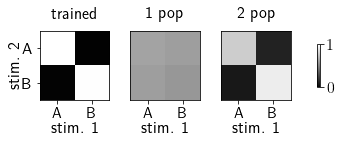

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(4.5, 1.5))
plt.rcParams['axes.labelsize'] = 17
plt.rcParams['axes.titlesize'] = 17

dms.psychometric_matrix(net, ax=ax[0])
dms.psychometric_matrix(net2, ax=ax[1])
dms.psychometric_matrix(net3, ax=ax[2])
# dms.psychometric_matrix(net_rec, ax=ax[1][1])

for axx in ax:
    axx.xaxis.tick_bottom()
    axx.set_xticks([0, 1])
    axx.set_xticklabels(['A', 'B'])
    axx.spines['top'].set_visible(True)
    axx.spines['right'].set_visible(True)
    axx.set_xlabel('stim. 1')

for axx in [ax[0]]:
    axx.set_yticks([0, 1])
    axx.set_yticklabels(['A', 'B'])
    axx.set_ylabel('stim. 2')
    
ax[0].set_title('trained')
ax[1].set_title('1 pop')
ax[2].set_title('2 pop')
# ax[1][1].set_title('reduced', pad=2)

fig.subplots_adjust(hspace=.6, wspace=.3)

w = .01
h = .4
ax_cbar = fig.add_axes((.98, .5 - h/2, w, h))
cmap = plt.get_cmap('gray')
matplotlib.colorbar.ColorbarBase(ax_cbar, cmap=cmap, orientation='vertical')
ax_cbar.set(yticks=[0, 1])
# plt.savefig('figure_3/dms_psycho.pdf', bbox_inches='tight')

<AxesSubplot:ylabel='accuracy'>

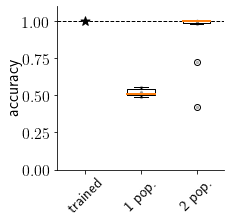

In [20]:
helpers.boxplot_accuracies([acc_orig, accs_normal, accs2], labels=['trained', '1 pop.', '2 pop.'],
                          figsize=(3, 3))
# plt.savefig('figure_3/dms_resampling.pdf', bbox_inches='tight')

In [21]:
## Simulating trajectories to visualize gain

dms.stimulus1_duration_min = 500
dms.stimulus1_duration_max = 500
dms.delay_duration_min = 1000
dms.delay_duration_max = 1000
dms.stimulus2_duration_min = 500
dms.stimulus2_duration_max = 500
dms.setup()
stim1_begin = dms.fixation_duration_discrete
stim1_end = stim1_begin + dms.min_stimulus1_duration_discrete
stim2_begin = dms.fixation_duration_discrete + dms.min_stimulus1_duration_discrete + dms.min_delay_duration_discrete
stim2_end = stim2_begin + dms.min_stimulus2_duration_discrete
x1, _, _, _, _, _ = dms.generate_dms_data(1, type='A-A')
outp, trajectories = net.forward(x1, return_dynamics=True)
trajectories = trajectories.detach().squeeze().numpy()
phi_primes1 = helpers.phi_prime(trajectories[stim1_begin:stim1_end].mean(axis=0))
x2, _, _, _, _, _ = dms.generate_dms_data(1, type='B-B')
outp, trajectories = net.forward(x2, return_dynamics=True)
trajectories = trajectories.detach().squeeze().numpy()
phi_primes2 = helpers.phi_prime(trajectories[stim1_begin:stim1_end].mean(axis=0))

x3 = torch.zeros((1, dms.total_duration, 2))
outp, trajectories = net.forward(x3, return_dynamics=True)
trajectories = trajectories.detach().squeeze().numpy()
phi_primes3 = helpers.phi_prime(trajectories[:dms.total_duration // 2].mean(axis=0))

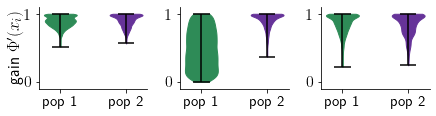

In [22]:
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.labelsize'] = 17
plt.rcParams['axes.titlepad'] = 12
plt.rcParams['xtick.labelsize'] = 15

fig, ax = plt.subplots(1, 3, figsize=(7, 1.5))

pl = ax[0].violinplot([phi_primes3[z==i] for i in range(2)])
for i, violin in enumerate(pl['bodies']):
    violin.set_facecolor(colors[i])
    violin.set_edgecolor(colors[i])
    violin.set_alpha(1)
pl['cbars'].set_color('black')
pl['cmins'].set_color('black')
pl['cmaxes'].set_color('black')
ax[0].set_ylim(-.1, 1.1)
ax[0].set_yticks([0, 1])
ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(['pop 1', 'pop 2'])
ax[0].set_ylabel('gain $\Phi\'(x_i)$')
# ax[0].set_title('No input')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

pl = ax[1].violinplot([phi_primes1[z==i] for i in range(2)])
for i, violin in enumerate(pl['bodies']):
    violin.set_facecolor(colors[i])
    violin.set_edgecolor(colors[i])
    violin.set_alpha(1)
pl['cbars'].set_color('black')
pl['cmins'].set_color('black')
pl['cmaxes'].set_color('black')
ax[1].set_ylim(-.1, 1.1)
ax[1].set_yticks([0, 1])
ax[1].set_xticks([1, 2])
ax[1].set_xticklabels(['pop 1', 'pop 2'])
# ax[1].set_title('Input A')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

pl = ax[2].violinplot([phi_primes2[z==i] for i in range(2)])
for i, violin in enumerate(pl['bodies']):
    violin.set_facecolor(colors[i])
    violin.set_edgecolor(colors[i])
    violin.set_alpha(1)
pl['cbars'].set_color('black')
pl['cmins'].set_color('black')
pl['cmaxes'].set_color('black')
ax[2].set_ylim(-.1, 1.1)
ax[2].set_yticks([0, 1])
ax[2].set_xticks([1, 2])
ax[2].set_xticklabels(['pop 1', 'pop 2'])
# ax[2].set_title('Input B')
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)

fig.subplots_adjust(wspace=.3)
# plt.savefig('figure_4/dms_violin.pdf', bbox_inches='tight')

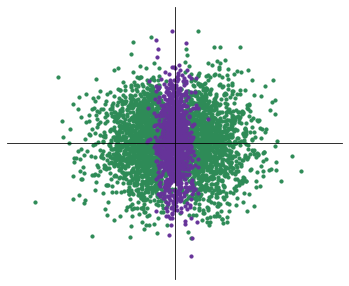

pop 0: slope=0.31, intercept=-0.04
pop 1: slope=0.96, intercept=-0.07


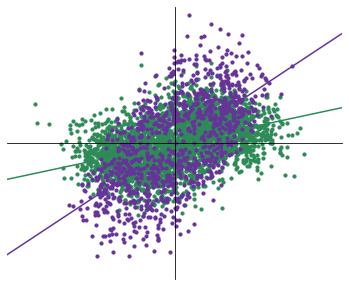

pop 0: slope=0.52, intercept=-0.03
pop 1: slope=-1.14, intercept=-0.03


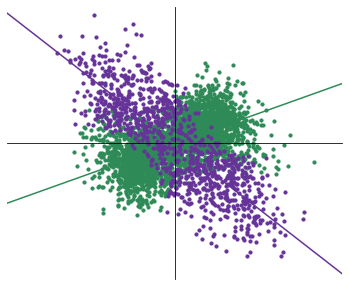

In [23]:
fig, ax = plt.subplots(figsize=(6, 5))
clustering.pop_scatter_linreg(wi1, wi2, z, 2, colors=colors, linreg=False, ax=ax)
# plt.savefig('si_networks/dms_scatter1.pdf', bbox_inches='tight')
plt.show()
fig, ax = plt.subplots(figsize=(6, 5))
clustering.pop_scatter_linreg(m1, n1, z, 2, colors=colors, ax=ax)
# plt.savefig('si_networks/dms_scatter2.pdf', bbox_inches='tight')
plt.show()
fig, ax = plt.subplots(figsize=(6, 5))
clustering.pop_scatter_linreg(m2, n1, z, 2, colors=colors, ax=ax)
# plt.savefig('si_networks/dms_scatter2.pdf', bbox_inches='tight')
plt.show()

[[ True False False False False False False]
 [ True  True False False False False False]
 [ True  True  True False False False False]
 [ True  True  True  True False False False]
 [ True  True  True  True  True False False]
 [ True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True]]
[[ 0.00000000e+00  3.44848320e-04  1.55476314e-01  2.48718637e-02
  -1.03208823e-03  1.85805124e-01  1.31995623e-03]
 [ 0.00000000e+00  0.00000000e+00  2.18642063e-02  2.08419300e-03
   2.62355867e-02  2.88424032e-02  8.28418810e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.23450115e+00
   7.99929239e-01  1.37617988e+00  2.96064293e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.59070585e+00  4.65408755e-01  8.37153160e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.07689581e+00  2.99661525e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00

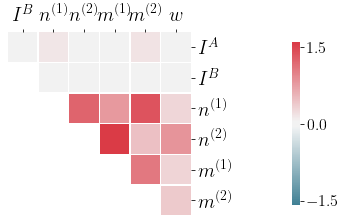

[[ True False False False False False False]
 [ True  True False False False False False]
 [ True  True  True False False False False]
 [ True  True  True  True False False False]
 [ True  True  True  True  True False False]
 [ True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True]]
[[ 0.00000000e+00 -4.70641740e-03 -1.54589272e-01  3.14874886e-02
   2.32476171e-01  1.00256969e-01  1.88897025e-02]
 [ 0.00000000e+00  0.00000000e+00  7.04747158e-02  1.11823055e-03
   3.56088496e-02 -3.45689981e-02 -1.14373176e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.41781704e+00
  -2.33248966e+00 -5.18161822e+00 -3.32954130e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.57789090e+00 -1.35707142e+00  4.96227841e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  3.03208652e+00  6.99427530e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00

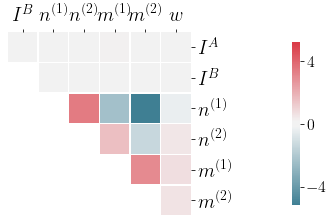

In [24]:
lsize = 20
plt.rcParams['text.usetex'] = True

for i in (0, 1):
    rescaled_vectors = [wi1[z==i], wi2[z==i], n1[z==i], m1[z==i], n2[z==i], m2[z==i], wo[z==i] / 4]
    ov = helpers.overlap_matrix(rescaled_vectors)
    labels = ['$I^A$', '$I^B$', '$n^{(1)}$', '$n^{(2)}$', '$m^{(1)}$', '$m^{(2)}$', '$w$']
    bound = np.max((np.abs(np.min(ov)), np.abs(np.max(ov))))
    fig, ax = plt.subplots(figsize=(6, 6))
    helpers.get_lower_tri_heatmap(ov, cbar=True, cbar_shrink=.5, figsize=(4, 3), cbar_pad=.3, ax=ax)
    ax.set_xticks(np.array(list(range(len(labels) - 1))) + .5)
    ax.set_xticklabels(labels[1:])
    ax.set_yticks(np.array(list(range(len(labels) - 1))) + .5)
    ax.set_yticklabels(labels[:-1])
    ax.xaxis.set_tick_params(labelsize=lsize, rotation=0)
    ax.yaxis.set_tick_params(rotation=0, labelsize=lsize)
    # plt.savefig(f'si_networks/dms_overlap{i}.pdf', bbox_inches='tight')
    plt.show()